Here I train a model on synthetic data without noise generated with an assumption that there is no cavity linewidth effect on the microwave transitions. I will try a fully-connected neural network (FCNN) and a convolutional neural network (CNN).

Import libraries

In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import pandas as pd

Load datasets. X is the DR signal vs microwave frequency. Y corresponds to the parallel and normal components of the DC field. Y-data is already normalized. I don't inc

In [6]:
X_train = np.load("..\Data\X_train1.npy")
Y_train = np.load('..\Data\Y_train1.npy')

X_test = np.load('..\Data\X_val1.npy')
Y_test = np.load('..\Data\Y_val1.npy')

Normalize data, so the DR signal is between zero and one.

In [7]:
Level = np.min(X_train)
Height = np.max(X_train)-np.min(X_train)

X_train = (X_train-Level)/Height
X_test = (X_test-Level)/Height

In [8]:
X_test

array([[1.        , 0.99999845, 0.99999686, ..., 0.99999686, 0.99999845,
        1.        ],
       [0.99999994, 0.99999839, 0.99999681, ..., 0.99999681, 0.99999839,
        0.99999994],
       [0.99999978, 0.99999822, 0.99999663, ..., 0.99999663, 0.99999822,
        0.99999978],
       ...,
       [0.99946675, 0.99943539, 0.99940158, ..., 0.99940158, 0.99943539,
        0.99946675],
       [0.99979513, 0.99978365, 0.99977142, ..., 0.99977142, 0.99978365,
        0.99979513],
       [0.99948509, 0.99945484, 0.99942223, ..., 0.99942223, 0.99945484,
        0.99948509]])

Plot normalized data

Text(0, 0.5, 'DR signal')

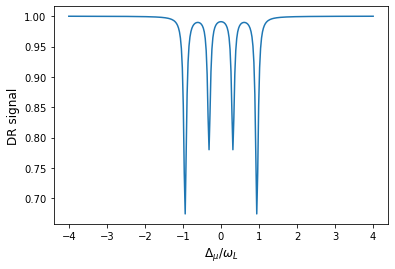

In [14]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-4,4,320), X_train[50])
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$', fontsize=12)
ax.set_ylabel('DR signal', fontsize=12)